# Making allele frequency plots

This notebook contains code to process the CRISPResso "allele frequency table" files from base editor validation experiments. The inputs are 2 input files: the first contains metainformation about each sample to make the "allele frequency" file, and the second contains metainformation to compute correlations between the log-normalized read counts. The output of this file are 3 files for each sgRNA / primer pair: 
1. a file containing all alleles and their read counts for each sample
2. a filtered version of (1) that only contains alleles with at least 1% abundance in any sample
3. a file containing the Pearson correlations between log-normalized read counts of each allele with > 100 reads in at least one sample

(1) is the starting file used to show the abundance of specific edits over time (code in BEV_aa_over_time.ipynb). (2) is the starting file used to create allele-level heatmaps (this was done using GraphPad Prism). (3) is the starting file for the plots showing the replicate correlation for validation experiments (actual plots were made using GraphPad Prism).

In [14]:
import pandas as pd 
import numpy as np 
import base_edit_functions as be
from math import log
from os import path
import sys, itertools
import re
from pathlib import Path
from IPython.display import Javascript, display


In [15]:
print('Python version: ' + sys.version)

Python version: 3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [16]:
modules = ['pandas', 'numpy']
for module in modules:
    try:
        print(module + ' ' + sys.modules[module].__version__)
    except:
        print(module + ' has no __version__ attribute')

pandas 1.2.1
numpy 1.19.5


## User inputs

<font color='blue'> Please follow steps indicated in blue, then run the notebook to generate output files. If the files are formatted as described in the documentation, the code in the 'Functions' section should not need to be altered. </font> 

### Load input files

**Metainformation file** 

<font color='blue'> <b>Step 1:</b> Create metainformation input file in the following format </font> 

**Columns**: 

* **sg** : sg identifier 
* **sgRNA_sequence** : sequence of sgRNA; <u>must be in the 5' to 3' direction, reverse complement if necessary</u>
* **ref_seq**: reference sequence outputted by CRISPResso formatted such that intronic sequences are lower-case and exons are upper-case (if applicable); <u> must be sequence on strand that is being translated; may not necessarily be the same strand as the sgRNA sequence</u> 
    * Ex. <font color='grey'>tgtcttttctatgatctctttag</font><font color='green'>GGGTGACCCAGTCTATT</font>
* **BEV_start** : BEV number for first sample in sg
* **BEV_end** : BEV number for last sample in sg
* **primer** : name of primer pair (joined by '\_') used to amplify genomic locus as mentioned in sample name
    * Ex. <font color='purple'>F_C12</font><font color = 'blue'><b>_</b></font><font color='green'>R_C12</font>
* **frame** : frame for translation (manually determined for each sg / primer pair); position of first coding nucleotide in reference sequence within codon; frame can be 1, 2, 3
    * Ex. given reference sequence: tgtcttttctatgatctctttag<font color='green'>**G**</font>G|GTG|ACC|CAG|TCT|ATT 
        since the first coding nucleotide of the reference sequence (<font color='green'><b>G</b></font>) is the 2nd nucleotide in its codon 
        (\_<font color='green'><b>G</b></font>G) &rightarrow; frame = 2
* **rev_com** : samples for which reference sequence is on reverse strand 
* **BEV_ref** : reference sample(s) for log-fold change (LFC) calculation (i.e. early time point, empty vector, etc.); if multiple BEV numbers are given, they should be separated by ';', and they will be treated as replicates that will be averaged
* **BEV_test** : test sample(s) for LFC calculation; if multiple BEV numbers are given, they should be separated by ';', and they will be treated as replicates that will be averaged

**Example input:**


| sg      | sgRNA_sequence       | ref_seq                                  | BEV_start | BEV_end | primer        | frame | rev_com | BEV_ref | BEV_test |
| ------- | -------------------- | ---------------------------------------- |  -------: |  -----: | ------------- |  ---: | ------: | ------- | -------- |
| 397   | GTCACCCCTAAAGAGATCAT | tgtcttttctatgatctctttagGGGTGACCCAGTCTATT | 7         | 12      |F_C12_R_C12 |  2    | True    | 5;6     | 9;10     |






<font color='blue'> <b> Step 2: </b> Enter filepath to metainformation input file here </font> 

In [17]:
input_file = pd.read_csv('AudreyData/Metainfo_input_f2_r1_ABE.csv')
# input_filepath = input("Please enter input filepath here: ")
# input_file = pd.read_csv(input_filepath)
input_file.head()

,sg,sgRNA_sequence,ref_seq,BEV_start,BEV_end,primer,frame,rev_com,BEV_ref,BEV_test
0,3,ACTTCTCCCGCCGCTACCGC,GCCGGCGACGACTTCTCCCGCCGCTACCGCCGCGACTTCG,327,336,F2_R1,1,False,327;328,335;336
1,4,ACGACTTCTCCCGCCGCTAC,CAGGCCGGCGACGACTTCTCCCGCCGCTACCGCCGCGACT,337,346,F2_R1,1,False,337;338,345;346
2,5,AGAAGTCGTCGCCGGCCTGG,TAGCGGCGGGAGAAGTCGTCGCCGGCCTGGCGGAGGGTCA,347,356,F2_R1,2,True,347;348,355;356


**Correlation Metainformation file** 

<font color='blue'><b>Step 3:</b> Create correlation input file in the following format  </font> 

**Columns**: 

* **sg** : sg identifier 
* **reps_for_correlation** : semicolon-separated BEV numbers of which to calculate the pairwise Pearson correlation of the log-normalized read counts

**Example input:**
    
| sg      | reps_for_correlation |
| ------- | -------------------: | 
| 397     | 7;8 | 
| 397     | 9;10 | 
| 397     | 11;12 | 


<font color='blue'><b>Step 4:</b> Enter filepath to correlation input file here  </font> 

In [18]:
corr_input = pd.read_csv('AudreyData/Correlation_input_f2r1_ABE.csv')
# corr_input_filepath = input("Please enter correlation input filepath here: ")
# corr_input = pd.read_csv(corr_input_filepath)
# corr_input.head()

### Specify folder filepaths 

<font color='blue'><b>Step 5:</b> Enter filepath to folder containing CRISPResso output files here. Please make sure that the filepath does not begin with a '/' but does end in a '/'.  </font> 

Please note that each folder containing CRISPResso output files for individual samples within the given folder should be named in the format 'CRISPResso_on_'+bev+'\_'+
primer, where bev = 'BEV' + sample_number and primer = primer name. 
Ex. <font color='grey'>CRISPResso_on</font><font color='purple'>_BEV_001</font><font color='green'>_F2_R2</font>

In [19]:
global CRISPResso_filepath 
CRISPResso_filepath = 'AudreyData/CRISPRessoBatch_on_F2R1_batch_file_v2/'
# CRISPResso_filepath = input("Please enter CRISPResso filepath here: ")

<font color='blue'><b>Step 6:</b> Enter filepath to folder where the files generated by this notebook will be stored. Please make sure that the filepath does not begin with a '/' but does end in a '/'. If the folders in this file path do not currently exist, they will be created when the notebook is run.  </font> 

In [20]:
# Filepath to store allele_freq output tables 
global output_filepath 
output_filepath = 'AudreyData/Validation_CRISPResso_results/allele_freq/'
# output_filepath = input("Please enter output folder filepath here: ")

<font color='blue'> <b>Ready to run functions!</b> </font> 

## Functions 

In [21]:
'''
This function removes any NaN rows from input_file
'''
def clean_input_file(df):
    df = df.dropna() #drop NaN 
    #dropna() converts int to float, so convert them back
    float_cols = df.select_dtypes(include=['float64']).columns #select subset of df of type float
    for col in float_cols: 
        #get original column index so can replace at correct loc
        index = df.columns.get_loc(col)
        #rename float cols as "float_"col name 
        float_col_name = 'float_' + col
        df = df.rename(columns = {col : float_col_name})
        #overwrite as type int
        float_to_int = df[float_col_name].astype(int).copy()
        df.insert(index, col, float_to_int)
        #drop float column 
        df = df.drop(float_col_name, axis = 1)
    return df

#check for NaN values i.e. blank rows
if input_file.isnull().values.any(): 
    input_file = clean_input_file(input_file)

In [22]:
'''
Called from: process_data_v2
Function: converts the BEV number from an int to a 3-digit string
'''
def get_bev_str(bev):
    bev = int(bev)
    if bev < 10:
        return '00'+str(bev)
    if bev < 100:
        return '0'+str(bev)
    return str(bev)
'''
Called from: get_path
Function: Verifies existence of filepath generated by get_path function to retrieve 'Alleles_frequency_table_around_sgRNA' file

INPUTS
------
filepath : filepath to 'Alleles_frequency_table_around_sgRNA_[].txt' file in CRISPResso output folder, 
           from get_path function
bev : BEV sample number 
sg_seq: guide sequence

OUTPUTS
-------
file_loc : filepath of 'Alleles_frequency_table_around_sgRNA_[].txt' file if exists
None if no filepath exists 

'''
def check_filepath(filepath,bev,primer,sg_seq):
    file_loc = filepath+'/CRISPResso_on_'+bev+'_'+primer+'/'+'Alleles_frequency_table_around_sgRNA_'+sg_seq+'.txt'
    if path.exists(file_loc):
        return file_loc
    return ''

'''
Called from: get_bev_files
Function: calls check_filepath to get filepath where CRISPResso output files are stored, 
whose folder path (CRISPResso_filepath) is provided above
Calls: check_filepath

INPUTS
------
bev_num : BEV sample number
primer: primer name (from input file)
sg_seq: guide sequence

OUTPUTS
-------
file_loc : filepath of 'Alleles_frequency_table_around_sgRNA_[].txt' file if exists
None if no filepath exists 

'''

def get_path(bev_num,primer,sg_seq):
    bev = 'NGBEV_' + get_bev_str(bev_num)
    filepath = CRISPResso_filepath
    return check_filepath(filepath,bev,primer,sg_seq)


'''
Called from: get_bev_files
Function: merges together the "Allele_frequency_table_around_sgRNA" files

INPUTS
------
filepath : filepath to 'Alleles_frequency_table_around_sgRNA_[].txt' file in CRISPResso output folder, 
           from get_path function
bev : BEV sample number 
sg_seq: guide sequence
existing_df: merge data frame with 'Aligned_Sequence' and 'Reference_Sequence' columns defined in get_bev_files
cols: empty list populated in function 

OUTPUTS
-------
merge : merged dataframe with Aligned_Sequence, Reference_Sequence, Reads columns from each sample 
cols: columns labeled with BEV sample number 
'''
def merge_bev_file(filepath,bev,sg_seq,existing_df,cols):
    if not path.exists(filepath):
        print('no file')
        return existing_df,cols
    df = pd.read_table(filepath,index_col=False)
    # Sum together any rows that share both 'Aligned Sequence' and 'Reference Sequence' with each other (this is rare)
    df_summed = df[['Aligned_Sequence','Reference_Sequence','#Reads','%Reads']].groupby(['Aligned_Sequence','Reference_Sequence'],as_index=False).agg('sum')
    cols.append(str('_BEV_'+str(bev)))
    df_summed = df_summed.rename(columns={'#Reads':str('#Reads_BEV_'+str(bev)),'%Reads':str('%Reads_BEV_'+str(bev))})
    # Outer merge onto existing dataframe
    merge = pd.merge(existing_df,df_summed,how='outer',on=['Aligned_Sequence','Reference_Sequence'])
    # Fill in nans with 0
    merge = merge.fillna(0)
    return merge,cols

'''
Called from: process_data_v2
Function: function gets and merges all "Allele_frequency_table_around_sgRNA" files for a given sgRNA sequence
(i.e. different replicates, drug conditions, etc.)
This is customized to work with files with the "BEV" notation
Calls: get_path, merge_bev_file

INPUTS
------
bev_list : contains BEV sample number, primer name, guide sequence for each sample  

OUTPUTS
-------
merge: merged dataframe with 
cols:

'''

def get_bev_files(bev_list):
    merge = pd.DataFrame(columns=['Aligned_Sequence','Reference_Sequence'])
    cols = []
    for bev,sg_seq,primer_name in bev_list:
        filepath = get_path(bev,primer_name,sg_seq)
        if filepath != '':
            merge,cols = merge_bev_file(filepath=filepath,bev=bev,sg_seq=sg_seq,existing_df=merge,cols=cols)
    return merge,cols

'''
Called from: process_data_v2
Function: filters out rows that don't meet given threshold (<1% for %Reads and <100 for #Reads)

INPUTS
------
row : row in column to which function is being applied (%Reads or #Reads)
cols: given cols (%Reads, #Reads for all samples )
val: threshold for filter 

OUTPUTS
-------
returns False for any rows (alleles) that have a value < the given value in ALL of the given cols

'''
def read_count_filter(row,cols,val):
    for col in cols:
        if row[col] > val:
            return True
    return False

'''
Called from: process_data_v2
Function: removes introns from Aligned_Sequence before translation

INPUTS
------
ref_seq: reference sequence from input file with intron sequence indicated by lowercase 
aligned: Aligned_sequence from merge df 
rev_com: True (from input file) if sequence needs to be reverse complemented 

OUTPUTS
-------
new_aligned: aligned sequence without introns and reverse complemented if necessary 

'''
def remove_introns(ref_seq, aligned, rev_com):
    #check for introns
    introns = re.compile('[a-z]+').findall(ref_seq)
    if not introns:
        #print('no introns')
        return 
    new_aligned = aligned.upper()
    new_introns = []    
    if rev_com:
        for i in introns:
            rev_com_intron = be.revcom(i.upper())
            new_introns.append(rev_com_intron)
    else:
        new_introns = introns
    for i in new_introns:
        if new_aligned.find(i.upper()) == -1: # if wild type intron not found, a splice site mutation may have occurred
            #print('not found')
            new_aligned = False
            #return new_aligned
        else: # if wild type intron found
            #print('found!')
            new_aligned = new_aligned.replace(i.upper(), '')
            if rev_com:
                new_aligned = be.revcom(new_aligned)
        return new_aligned

    
'''
Called from: process_data_v2
Function: translates Aligned_sequence to give amino acid sequence

INPUTS
------
seq: Aligned_sequence (after removing introns and/or reverse complementing if applicable)
frame: frame from input file 
rev_com: from input file; True if sequence needs to be reverse complemented 

OUTPUTS
-------
aa: amino acid sequence

'''
# This function returns the translation of a given sequence and frame
# This function returns the translation of a given sequence and frame
def translate(seq, frame, codon_map):
    if not seq: # if remove_introns returned False -> possible splice site mutation
        return 'Possible splice site mutation'
    aa = ''
    i = 0
    while i < len(seq)-1:
        substring = ''
        while frame <= 3:
            if i<len(seq):
                if seq[i] == '-':
                    #print('deletion')
                    i += 1
                    # frame doesn't change
                else:
                    substring += seq[i]  
                    i += 1
                    frame+=1
            else: # if reached end of the sequence and frame still <=3
                frame = 4
                continue
            #print('substring:', substring, 'i = ', i, 'frame = ', frame)
        if len(substring) == 3:
            frame = 1
            #if 'N' in substring:
            if ('N' in substring):
                aa = aa + '-'

            else:
                aa = aa + codon_map[substring]
        else:
            frame = 1
    return aa

codon_map = {'TTT':'F', 'TTC':'F', 'TTA':'L', 'TTG':'L', 'CTT':'L', 'CTC':'L', 'CTA':'L', 'CTG':'L', 'ATT':'I', 'ATC':'I',
             'ATA':'I', 'ATG':'M', 'GTT':'V', 'GTC':'V', 'GTA':'V', 'GTG':'V', 'TCT':'S', 'TCC':'S', 'TCA':'S', 'TCG':'S',
             'CCT':'P', 'CCC':'P', 'CCA':'P', 'CCG':'P', 'ACT':'T', 'ACC':'T', 'ACA':'T', 'ACG':'T', 'GCT':'A', 'GCC':'A',
             'GCA':'A', 'GCG':'A', 'TAT':'Y', 'TAC':'Y', 'TAA':'*', 'TAG':'*', 'CAT':'H', 'CAC':'H', 'CAA':'Q', 'CAG':'Q',
             'AAT':'N', 'AAC':'N', 'AAA':'K', 'AAG':'K', 'GAT':'D', 'GAC':'D', 'GAA':'E', 'GAG':'E', 'TGT':'C', 'TGC':'C',
             'TGA':'*', 'TGG':'W', 'CGT':'R', 'CGC':'R', 'CGA':'R', 'CGG':'R', 'AGT':'S', 'AGC':'S', 'AGA':'R', 'AGG':'R',
             'GGT':'G', 'GGC':'G', 'GGA':'G', 'GGG':'G'}

'''
This function checks for WT allele (if Aligned_Sequence = Reference_Sequence)

INPUTS
------
row : row of merge dataframe 

OUTPUTS
-------
returns True if the allele is unedited (i.e. WT) and False otherwise

'''
def get_wt_col(row):
    if row['Aligned_Sequence'] == row['Reference_Sequence']:
        return True
    else:
        return False

'''
This function calculates the LFC

INPUTS
------
row : row of metainformation input file containing BEV_test and BEV_ref columns
data_file : merged dataframe containing log-normalized rpm for each allele

OUTPUTS
-------
data_file : merged dataframe, now with LFC columns for each BEV test / ref pair

'''
def get_lfc_v2(row,data_file):
    cols = []
    bev_list = row['BEV_test'].split(';')
    
    # Go through each test sample in BEV_test column
    for i,bev in enumerate(bev_list):
        test = get_bev_str(bev)
        
        # Get reference sample for LFC from BEV_ref column
        ref = get_bev_str(row['BEV_ref'].split(';')[i])
        
        # Calculate LFC
        data_file['LFC_'+test+'-'+ref] = data_file['#Reads_BEV_'+test+';lognorm'] - data_file['#Reads_BEV_'+ref+';lognorm']  
        cols.append('LFC_'+test+'-'+ref)
        
    # Average together LFC columns
    data_file['AvgLFC_'+'_'.join(bev_list)] = data_file.loc[:,cols].mean(axis=1)
    return data_file


'''
Called from: run
Function: merges read counts (filtered), lognorms, aligned sequences, reference sequences, translations from 
test and reference samples for sgRNA 

INPUTS
------
data : deduplicated input file with column 'sg','BEV_start','BEV_end','sgRNA_sequence','primer','frame','rev_com'

OUTPUTS
-------
merge : merged dataframe with filtered read counts, lognorms, aligned sequences, reference sequences, translations

'''
        
def process_data_v2(data):
    bev_list = [] # list to store info for retrieving CRISPResso files for given sgRNA
    ref_nums = [] # list to store BEV numbers for CRISPResso files for reference samples 
    for i,row in data.iterrows():
        for bev in range(row['BEV_start'],row['BEV_end']+1):
            # store BEV number, sgRNA sequence, and primer name to get corresponding CRISPResso files 
            bev_list.append((get_bev_str(bev),row['sgRNA_sequence'],row['primer']))
        
        # if reference samples outside of BEV_start and BEV_end range, add to bev_list separately
        BEV_ref = data['BEV_ref'].copy().tolist() #.copy.loc['BEV_ref']))
        BEV_ref_split = BEV_ref[0].split(';')
        for num in BEV_ref_split:
            # check if reference sample numbers outside of BEV_start and BEV_end range
            if ((int(num) < row['BEV_start']) | (int(num) > row['BEV_end'])):
                ref_nums.append(num)
            else:
                continue
        for ref_num in ref_nums:
            # store BEV number, sgRNA sequence, and primer name to get corresponding CRISPResso files 
            bev_list.append((get_bev_str(ref_num),row['sgRNA_sequence'],row['primer']))
        print(bev_list)
    
    # Call get_bev_files function which merges Alleles_frequency_tables_around_sgRNA for given sgRNA  
    merge,cols = get_bev_files(bev_list)
    
    # Calculate log-normalized reads per million for each col
    for col in ['#Reads'+col for col in cols]:
        colsum = merge[col].sum()
        merge.loc[:,str(col+';lognorm')] = merge[col].apply(lambda x: log((float(x)/float(colsum))*1000000 + 1,2))
        
    # Apply read count filter
    merge.loc[:,'%read_count_filter'] = merge.apply(read_count_filter,args=(['%Reads'+col for col in cols],1),axis=1) # less than 1% of all reads
    merge.loc[:,'#read_count_filter'] = merge.apply(read_count_filter,args=(['#Reads'+col for col in cols],100),axis=1) # less than 100 reads
    
    # Before translating, check if there are introns in ref_seq column in input file
    # introns indicated by lowercase letters in ref_seq column 
    # Returns true if intron in ref_seq (i.e. if lowercase letters in input ref_seq)
    intron_flag = any(c.islower() for c in str(data.loc[data.index[0], 'ref_seq']))
    # if introns exist, remove introns before translating 
    if intron_flag:
        print('introns exist')
        intron_input_df = pd.DataFrame()
        intron_input_df['Aligned_Sequence'] = merge.loc[:,'Aligned_Sequence'].copy()
        intron_input_df['ref_seq'] = data['ref_seq'].to_list()[0]
        intron_input_df['rev_com'] = data.loc[i, 'rev_com']
        
        # Call remove_introns function to remove introns from aligned sequence before translating 
        intron_input_df['Translate_input']= list(map(remove_introns, intron_input_df['ref_seq'], intron_input_df['Aligned_Sequence'], intron_input_df['rev_com']))
        
        # Call translate function to translate new (intron-free) sequence  
        merge.loc[:,'Translated'] = intron_input_df['Translate_input'].apply(translate, args =(row['frame'],codon_map,))

    # if no introns
    else:
        # check if Aligned Sequence needs to be reverse complemented before translating 
        rev_com = data.loc[i, 'rev_com']
        if rev_com:
            merge.loc[:,'Aligned_Sequence'] = merge.loc[:,'Aligned_Sequence'].apply(be.revcom)
            merge.loc[:,'Reference_Sequence'] = merge.loc[:,'Reference_Sequence'].apply(be.revcom)
        # Call translate function to translate Aligned Sequence (reverse complemented if necessary) 
        merge.loc[:,'Translated'] = merge.loc[:,'Aligned_Sequence'].apply(translate,args=(row['frame'],codon_map,))

    return merge
'''
Called from: run
Function: joins all possible combinations of #Reads;lognorms columns from samples for given sgRNA 

INPUTS
------
row : #Reads;lognorm columns 

OUTPUTS
-------
columns joined by '_' : '#Reads_BEV_#;lognorm column_#Reads_BEV_#;lognorm column'
Ex. '#Reads_BEV_041;lognorm_#Reads_BEV_042;lognorm'  

'''

def get_corr_name(row):
    cols = [row['R1'],row['R2']]
    cols.sort()
    return '_'.join(cols)

'''
Called from: run
Function: gets combinations of samples specified in reps_for_correlation column in correlation input 

INPUTS
------
corr_input : correlation input file 
sg: guide identifier from corr_input

OUTPUTS
-------
combos : '#Reads_BEV_#;lognorm column_#Reads_BEV_#;lognorm column' for pairs specified in corr_input  

'''


def get_correlation_cols(corr_input,sg):
    corr_input = corr_input.loc[corr_input['sg'] == sg,:]
    combos = []
    for i,r in corr_input.iterrows():
        bevs = r['reps_for_correlation'].split(';')
        bevs = ['#Reads_BEV_'+get_bev_str(bev)+';lognorm' for bev in bevs]
        if len(bevs) > 1:
            combos.extend(itertools.combinations(bevs,2))
    combos = ['_'.join(combo) for combo in combos]
    return combos


In [23]:
'''
This function calls all previous functions to generate output tables 

INPUTS
------
input_file : input file with columns 'sg', 'ref_seq', 'sgRNA_sequence', 'BEV_start', 'BEV_end', 'primer',
       'frame', 'rev_com', 'BEV_ref', 'BEV_test' described above
corr_input : input file with columns 'sg', 'reps_for_correlation' described above

OUTPUTS
-------
output files stored in output_filepath given above

'''

def run(input_file,corr_input):
    
    # List of sgRNA identifiers provided in "sg" column of input file
    sg_list = list(set(input_file['sg'].tolist())) # drop duplicates from list

    # Go through each sgRNA separately    
    for sg in sg_list:
        print(sg)
        
        # Filter input file to contain only rows for given sgRNA
        data = input_file.loc[input_file['sg'] == sg,:]
        
        # Merge all the allele read counts
        # To do this, drop the BEV_test and BEV_ref columns (which just have information needed for the LFC calculation)
        # Then drop duplicate rows
        data_dedup = data.drop_duplicates(subset=['sg','BEV_start','BEV_end','sgRNA_sequence','primer','frame','rev_com'])
        
        # Call process_data_v2 function which adds the following columns to output table:
        #read counts, lognorms, aligned sequences, reference sequences, translations 
        merge = process_data_v2(data_dedup)
        
        # Get the WT column
        merge['WT'] = merge.apply(get_wt_col,axis=1)
        
        # Now, go through each row and calculate the LFC for each of the pairs specified in BEV_test and BEV_ref
        for i,r in data.iterrows():               
            merge = get_lfc_v2(r,merge)
        #print(merge.head())
            
        # Write out 2 files: full file (merge) and filtered file (only including alleles with > 1% reads in at least one condition)
        Path(output_filepath).mkdir(parents=True, exist_ok=True)
        merge.to_csv(output_filepath +str(r['sg'])+'_'+r['primer']+'_allele_frequency_table_around_sgRNA.csv',index=False)
        filtered = merge[merge['%read_count_filter'] == True]
        filtered.to_csv(output_filepath +str(r['sg'])+'_'+r['primer']+'_filtered_allele_frequency_table_around_sgRNA.csv',
                        index=False)            

        # Get correlations matrix of log-normalized rpm, using only alleles with > 100 reads in at least one sample
        merge = merge[merge['#read_count_filter'] == True]
        cols = [x for x in list(merge) if 'lognorm' in x]
        correlations = merge[cols].corr(method='pearson')
        correlations['R1'] = correlations.index
        correlations = correlations.melt(id_vars = 'R1', value_vars=list(correlations).remove('R1'),var_name='R2',value_name='Pearson')
        
        # Drop correlations that are not specified in corr_input
        correlations['Reps'] = correlations.apply(get_corr_name,axis=1)
        combos = get_correlation_cols(corr_input,sg)
        correlations = correlations[correlations['Reps'].isin(combos)]
        
        # Drop duplicate rows (i.e. A vs B and B vs A)
        correlations = correlations.drop_duplicates(subset=['Reps'])
        
        # Write to file
        Path(output_filepath + "corr_outputs/#read_count_filter_pearson/").mkdir(parents=True, exist_ok=True)
        correlations.to_csv(output_filepath + "corr_outputs/#read_count_filter_pearson/sg" +str(r['sg'])+'_'+r['primer']+'_correlations.csv')
        
    return 
    

Now, we run the two input files and produce allele tables for all sgRNAs.

In [24]:
run(input_file,corr_input)

3
[('327', 'ACTTCTCCCGCCGCTACCGC', 'F2_R1'), ('328', 'ACTTCTCCCGCCGCTACCGC', 'F2_R1'), ('329', 'ACTTCTCCCGCCGCTACCGC', 'F2_R1'), ('330', 'ACTTCTCCCGCCGCTACCGC', 'F2_R1'), ('331', 'ACTTCTCCCGCCGCTACCGC', 'F2_R1'), ('332', 'ACTTCTCCCGCCGCTACCGC', 'F2_R1'), ('333', 'ACTTCTCCCGCCGCTACCGC', 'F2_R1'), ('334', 'ACTTCTCCCGCCGCTACCGC', 'F2_R1'), ('335', 'ACTTCTCCCGCCGCTACCGC', 'F2_R1'), ('336', 'ACTTCTCCCGCCGCTACCGC', 'F2_R1')]
4
[('337', 'ACGACTTCTCCCGCCGCTAC', 'F2_R1'), ('338', 'ACGACTTCTCCCGCCGCTAC', 'F2_R1'), ('339', 'ACGACTTCTCCCGCCGCTAC', 'F2_R1'), ('340', 'ACGACTTCTCCCGCCGCTAC', 'F2_R1'), ('341', 'ACGACTTCTCCCGCCGCTAC', 'F2_R1'), ('342', 'ACGACTTCTCCCGCCGCTAC', 'F2_R1'), ('343', 'ACGACTTCTCCCGCCGCTAC', 'F2_R1'), ('344', 'ACGACTTCTCCCGCCGCTAC', 'F2_R1'), ('345', 'ACGACTTCTCCCGCCGCTAC', 'F2_R1'), ('346', 'ACGACTTCTCCCGCCGCTAC', 'F2_R1')]
5
[('347', 'AGAAGTCGTCGCCGGCCTGG', 'F2_R1'), ('348', 'AGAAGTCGTCGCCGGCCTGG', 'F2_R1'), ('349', 'AGAAGTCGTCGCCGGCCTGG', 'F2_R1'), ('350', 'AGAAGTCGTCGCCGGC

## Heatmap

Finally, we generate allele-level heat maps annotated with corresponding allele amino acid sequences and tables with average % reads for each allele at early and late time points.

By default, early time point samples are considered to be the same as the BEV_ref samples and the late time point samples are considered to be the BEV_test samples. If this is not the case (e.g.,  BEV_test samples span multiple time points), please upload a file with the following columns: 

**Columns**: 

* **sg** : sg identifier 
* **Time point** : string that identifies time point 
* **BEV_num** : semicolon-separated BEV numbers corresponding to samples at that time point 

**Example input:**
    
| sg      |time_point | BEV_nums |
| ------- |------- | -------------------: | 
| 397     |D8      |  7;8 | 
| 397     |D14      | 9;10 | 
| 397     |D21      | 11;12 | 


In [30]:
global timepoint_input_file

# Check if default settings work for user
default_y_or_n = input("Do the default time point sample assignments work for you? Please enter 'y' or 'n'. If 'n', you will be asked to enter the path to a time point input file as described above. ")

Do the default time point sample assignments work for you? Please enter 'y' or 'n'. If 'n', you will be asked to enter the path to a time point input file as described above. y


In [40]:
if default_y_or_n == 'y':
    timepoint_input_file = None
    print('y')
elif default_y_or_n == 'n':
    timepoint_input_filepath = input("Please enter input filepath here: ")
    # timepoint_input_file = pd.read_csv('AnnabelData/timepoint_df_test.csv')
    timepoint_input_file = pd.read_csv(timepoint_input_filepath)
    print('n')
else:
    raise Exception('Invalid input. Please enter either \'y\' or \'n\' and re-run the cell.')

y


In [41]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable

rcParams['font.family'] = 'monospace' #so translated sequences are aligned
rcParams['font.monospace'] = 'Arial'
rcParams['font.size']: 12.0

'''
This function generates allele-level heatmaps using log-fold changes for each validation condtion
annotated with the corresponding allele amino acid sequences

INPUTS
------
df : input file with columns 'sg', 'ref_seq', 'sgRNA_sequence', 'BEV_start', 'BEV_end', 'primer',
       'frame', 'rev_com', 'BEV_ref', 'BEV_test' described above
vmin : sets minimum value for heatmap color bar
vmax: sets maximum value for heatmap color bar
filepath: same as output_filepath specified above where allele frequency output tables are saved 
time1: (optional) string describing early time point for table header, e.g. 'Day7' (default: 'Time1')
time2: (optional) string describing late time point for table header, e.g. 'Day14' (default: 'Time2')

OUTPUTS
-------
1. allele-level heatmpas with corresponding allele amino acid sequences annotated
2. tables with average % reads for each allele at early and late time points 

'''

def heatmaps(df,vmin,vmax,filepath, time1 = 'Time1', time2 = 'Time2', timepoint_df=None, filename = 'translation_heatmap', **kwargs):

    num_rows = len(df)
    num_cols = 2
    fig,axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*4,num_rows*4))
    plt.subplots_adjust(wspace=0.5, hspace = 0.5)
    
    row_count = 0
    
    for num, (i,r) in enumerate(df.iterrows()):

        sg = r['sg']
#         print('before plot sg: ', sg)
        primer = r['primer']
        location = filepath+str(sg)+'_'+primer+'_filtered_allele_frequency_table_around_sgRNA.csv'
        to_plot = pd.read_csv(location)

        avgLFC_col = [col for col in to_plot.columns if 'AvgLFC' in col][0]

        to_plot.sort_values(by=avgLFC_col,ascending=False,inplace=True)
        
        # Earlier time point -> Time1
        time1_avg_col = 'Avg%Reads_' + time1
        
        # Later time point -> Time 2
        time2_avg_col = 'Avg%Reads_' + time2
        
        if timepoint_df is None: # Default to BEV_ref as Time1 samples and BEV_test as Time2 samples
            
            # Default Time 1 (Earlier time point) samples  = BEV_ref columns 
            time1_samples = r['BEV_ref'].split(';') # convert to list of BEV numbers

            # Default Time 2 (Later time point) samples  = BEV_ref columns 
            time2_samples = r['BEV_test'].split(';') # convert to list of BEV numbers 
            
        else: # if timepoint_df provided
            # Get Time 1 columns from df based on time1 parameter 
            sg_timepoint_df = timepoint_df[timepoint_df['sg']==sg]
            time1_sample_df = sg_timepoint_df[sg_timepoint_df['time_point']==time1].reset_index(drop=True)
            time1_samples = time1_sample_df.loc[0, 'BEV_nums'].split(';')
            
            # Get Time 2 columns from df based on time2 parameter 
            sg_timepoint_df = timepoint_df[timepoint_df['sg']==sg]
            time2_sample_df = sg_timepoint_df[sg_timepoint_df['time_point']==time2].reset_index(drop=True)
            time2_samples = time2_sample_df.loc[0, 'BEV_nums'].split(';')
        
        # Lists to store correctly formatted %Reads column names 
        time1_cols = [] 
        time2_cols = []
        
        # %Reads columns named "%Reads_BEV_" + get_bev_str(int(BEV_num))
        for num in time1_samples:
            col_name = "%Reads_BEV_" + get_bev_str(int(num))
            time1_cols.append(col_name)  

        to_plot[time1_avg_col] = round(to_plot[time1_cols].apply(np.mean,axis=1),1).apply(str)#+'%'

        # %Reads columns named "%Reads_BEV_" + get_bev_str(int(BEV_num))
        for num in time2_samples:
            col_name = "%Reads_BEV_" + get_bev_str(int(num))
            time2_cols.append(col_name)  

        to_plot[time2_avg_col] = round(to_plot[time2_cols].apply(np.mean,axis=1),1).apply(str)#+'%'

        to_plot['Label'] = to_plot['Translated']

        reads_df = to_plot[[time1_avg_col, time2_avg_col]]

        to_plot.loc[to_plot['WT'],'Label'] = to_plot.loc[to_plot['WT'],'Label'].values[0] + '<wt' 

        heatmap_df = to_plot[['Label',[col for col in to_plot.columns if 'AvgLFC' in col][0]]].reset_index(drop = True)
        
        if row_count < num_rows:
            # HEATMAP
            if num_rows == 1: 
                heatmap_ax = axs[0]
            else: 
                heatmap_ax = axs[row_count, 0]

            sns.heatmap(heatmap_df.set_index('Label'),cmap='RdBu_r',vmin=vmin,vmax=vmax,ax=heatmap_ax,annot=True,fmt='.1f')
            label_list = [item for item in heatmap_ax.get_yticklabels()]
            for label in label_list:
                if '<wt' in label.get_text():
                    label.set_color('red')
            plt.setp(heatmap_ax.get_yticklabels(), rotation=0, ha="left", size = 12)#,rotation_mode="anchor")

            yax = heatmap_ax.get_yaxis()
            # find the maximum width of the label on the major ticks
            pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
            yax.set_tick_params(pad=pad)
            heatmap_ax.set_ylabel('', rotation = 0)
            heatmap_ax.set_title(sg)
                    
            bbox = heatmap_ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            width, height = bbox.width, bbox.height

            # TABLE
            cell_text = []
            for row in range(len(reads_df)):
                cell_text.append(reads_df.iloc[row])
            
            if num_rows == 1: 
                table_ax = axs[1]
            else: 
                table_ax = axs[row_count, 1]
            #print('table position:', table_ax)
            translations = list(heatmap_df['Label'])
            #print(translations)
            cell_height = height/(2*(len(translations)))

            reads_table = table_ax.table(cellText=cell_text, colLabels=reads_df.columns, loc='center', cellLoc = 'center', edges = 'open')#, bbox = [0,0, width, height/2.3])
            reads_table.auto_set_font_size(False)
            reads_table.set_fontsize(12)
            reads_table.auto_set_column_width(col=list(range(len(reads_df.columns))))
            #reads_table.scale(1, 1.5)
            cellDict = reads_table.get_celld()
            
            for i in range(0,len(reads_df.columns)):
                cellDict[(0,i)].set_height(cell_height)
                for j in range(1,len(reads_df)+1):
                    cellDict[(j,i)].set_height(cell_height)
            table_ax.set_axis_off()
            

            row_count+=1
#             print(row_count)
#             break
    # Create path to Figures folder if doesn't exist already
    Path(filepath + '/Figures/').mkdir(parents=True, exist_ok=True)
    full_filepath = filepath + 'Figures/' + filename +'.pdf'
    print(full_filepath)
    plt.savefig(full_filepath,bbox_inches="tight")



AudreyData/Validation_CRISPResso_results/allele_freq/Figures/BRCA1_ABE_heatmap.pdf


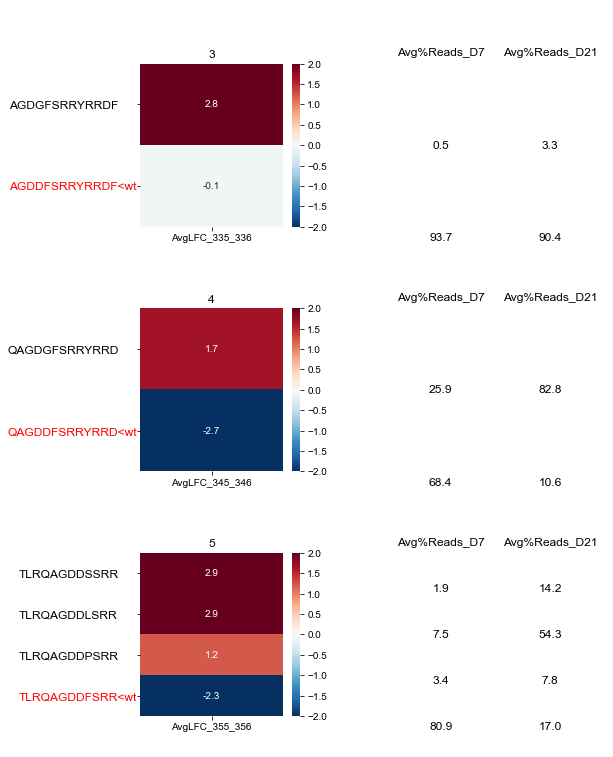

In [42]:
heatmaps(df = input_file,
         vmin = -2,
         vmax = 2,
         filepath = output_filepath,
         time1 = 'Time1',
         time2 = 'Time2',
         timepoint_df = timepoint_input_file,
         filename = 'BRCA1_ABE_heatmap'
        )